/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_65179/213715127.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  Transition = torch.tensor([[0.0, params.p1E, 1-params.p1E, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],


tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5618e-07, 1.5767e-07, 1.5993e-07,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9910e-04, 6.0618e-04, 6.1674e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


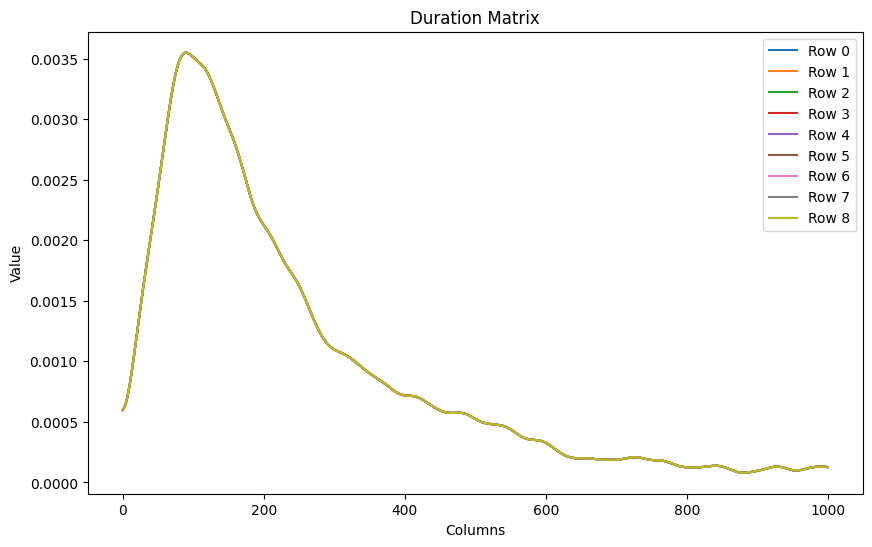

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import params
import tqdm.auto as tqdm
from collections import deque

# 0=S, 1=Es, 2=Ef, 3=Em, 4=El, 5=I, 6=5', 7=3', 8=epsilon
states = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Transition = torch.tensor([[0.0, params.p1E, 1-params.p1E, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 1-params.pEO, params.pEO, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

Duration = torch.zeros(9, 5000000)
Duration[0, 0] = 1
Duration[1] = torch.tensor(params.lengthSingleExons)
Duration[2] = torch.tensor(params.lengthFirstExons)
Duration[3] = torch.tensor(params.lengthMiddleExons)
Duration[4] = torch.tensor(params.lengthLastExons)
Duration[5] = torch.tensor(params.lengthIntrons)
Duration[6, 0] = 1
Duration[7, 0] = 1
Duration[-1, 0] = 1
print(Duration)

# Plotting the matrix
plt.figure(figsize=(10, 6))
for i in range(Duration.shape[0]):
    plt.plot(Duration[2, :1000].numpy(), label=f"Row {i}")

plt.xlabel("Columns")
plt.ylabel("Value")
plt.title("Duration Matrix")
plt.legend(loc="upper right")
plt.show()



tensor([[1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
torch.Size([9, 1202])


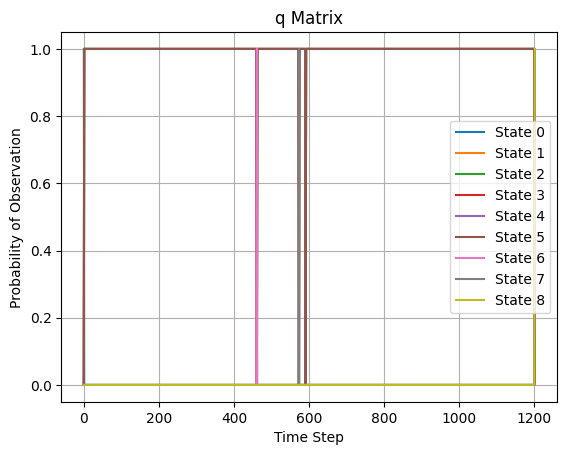

In [3]:
q3 = torch.tensor([[1], [0], [0]]).repeat(1, 1200) # [[null],[5'],[3']]
q3[:, 460] = torch.tensor([0, 1, 0]) # 5' site
q3[:, 572] = torch.tensor([0, 0, 1]) # 3' site
q3[:, 590] = torch.tensor([0.4, 0.6, 0]) # 5' site
print(q3)
q = torch.zeros(9, q3.shape[1])
q[1:6] = q3[0, :]
q[6] = q3[1, :]
q[7] = q3[2, :]
start = torch.zeros(9, 1)
start[0] = 1.0
end = torch.zeros(9, 1)
end[-1] = 1.0
q = torch.cat((start, q, end), dim=1)

print(q.shape)
# plot
time_steps = range(len(q[0]))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(q[1]))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def matrix_mult_factor(log_alpha_row, Transition):
    """
    returns a scalar
    """
    alpha_row = torch.exp(log_alpha_row)
    alpha_row = alpha_row.to(torch.float64)
    product = alpha_row @ Transition
    factor = torch.sum(product)
    return torch.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    """
    returns a vectors with dimensions (1, 9)
    """
    log_alpha_row = log_alpha_row.to(torch.float64)
    result = torch.exp(log_alpha_row)@Transition
    if torch.sum(result) != 0:
        return torch.log(result / torch.sum(result))
    else:
        return torch.zeros_like(result)

In [15]:
def forward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    # log_alpha_list = []
    log_alpha = torch.zeros((T, N))
    start = torch.zeros(N)
    start[0] = 1
    epsilon = 1e-13

    Transition_ep = Transition + epsilon
    Duration_ep = Duration + epsilon
    q_ep = q + epsilon
    start_ep = start + epsilon

    cum_q_ep = torch.cumsum(torch.log(q_ep), axis=1)

    # # initialization
    # for t in tqdm.trange(min(D, T)):
    #     cumulative_terms = cum_q_ep[:, t]
    #     new_log_alpha = torch.log(start_ep) + torch.log(Duration_ep[:, t]) + torch.sum(torch.log(q_ep[:, :t+1]), dim=1)
    #     for d in range(t):
    #         factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition_ep)]*N) # calculate ahead of time
    #         vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition_ep) # same as above
    #         subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
    #         add_term = factor + vector + torch.log(Duration_ep[:, d]) + cumulative_terms - subtract_term # try to calcualte in one go
    #         new_log_alpha = torch.logaddexp(new_log_alpha, add_term).squeeze()
    #     log_alpha_list.append(new_log_alpha)

    for t in tqdm.trange(min(D, T)):
        cumulative_terms = cum_q_ep[:, t]
        log_alpha[t] = torch.log(start_ep) + torch.log(Duration_ep[:, t]) + torch.sum(torch.log(q_ep[:, :t+1]), dim=1)
        # print(log_alpha[t])
        valid_d = torch.arange(t)
        log_alpha_idx = t-valid_d-1
        log_alphas = log_alpha[log_alpha_idx]
        # refactor factor and vec function
        factors = torch.stack([matrix_mult_factor(log_alphas, Transition_ep)]*N)
        vectors = matrix_mult_vec(log_alphas, Transition_ep)
        # print(vectors)
        subtract_terms = cum_q_ep[:, log_alpha_idx].T
        # print(factors.shape, vectors.shape, subtract_terms.shape, cumulative_terms.shape, torch.log(Duration_ep[:, valid_d]).T.shape)
        # print(factors, vectors)
        add_terms = factors + vectors + torch.log(Duration_ep[:, valid_d].T) + cumulative_terms - subtract_terms
        log_alpha[t] = torch.logaddexp(log_alpha[t], add_terms).squeeze()
        
    # # fill log_alpha[D:]
    # for t in tqdm.trange(D, T):
    #     cumulative_terms = cum_q_ep[:, t]
    #     log_alpha_list.append(torch.full((N,), -float('inf')))
    #     new_log_alpha = log_alpha_list[t]
    #     for d in range(D):
    #         factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition_ep)]*N)
    #         vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition_ep)
    #         subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
    #         add_term = factor + vector + torch.log(Duration_ep[:, d]) + cumulative_terms - subtract_term
    #         new_log_alpha = torch.logaddexp(new_log_alpha, add_term).squeeze()
    #     log_alpha_list[t] = new_log_alpha

    for t in tqdm.trange(D, T):
        cumulative_terms = cum_q_ep[:, t]
        log_alpha[t] = torch.full((N,), -float('inf'))
        valid_d = torch.arange(D)
        log_alpha_idx = t-valid_d-1
        log_alphas = log_alpha[log_alpha_idx]
        factors = torch.stack([matrix_mult_factor(log_alphas, Transition_ep)]*N)
        vectors = matrix_mult_vec(log_alphas, Transition_ep)
        subtract_terms = cum_q_ep[:, log_alpha_idx].T
        add_terms = factors + vectors + torch.log(Duration_ep[:, valid_d].T) + cumulative_terms - subtract_terms
        log_alpha[t] = torch.logaddexp(log_alpha[t], add_terms).squeeze()    


    log_alpha = torch.exp(torch.stack(log_alpha))
    return log_alpha


fwd = forward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(q[0]))]
    plt.plot(time_steps, np.log(probs), label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

  0%|          | 0/1202 [00:00<?, ?it/s]

tensor([], size=(0, 9), dtype=torch.float64) tensor([], size=(0, 9))
tensor([  0.0000, -75.5395, -67.2873, -68.5816, -67.5837, -89.8008, -59.8672,
        -59.8672, -59.8672]) tensor([], size=(0, 9), dtype=torch.float64)


RuntimeError: expand(torch.DoubleTensor{[0, 9]}, size=[9]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

  0%|          | 0/1201 [00:00<?, ?it/s]

q.grad None
[1. 1. 1. 1. 1. 1. 1. 1. 1.] [1.00055428e-13 1.00000000e+00 1.99999915e-13 1.99999915e-13
 1.00000000e+00 1.99999915e-13 9.99999102e-14 1.00019175e-13
 9.99999102e-14]


/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_51474/160921015.py:55: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")


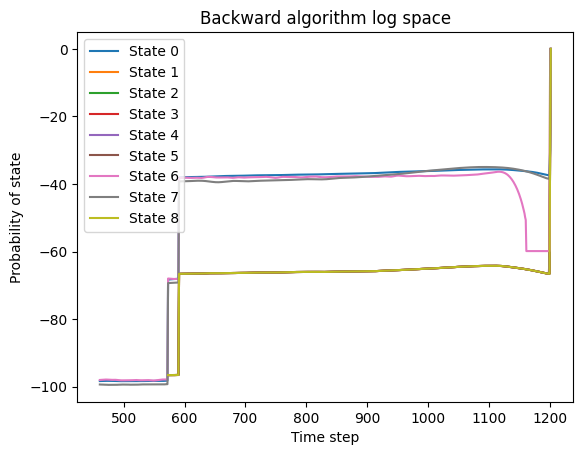

In [ ]:
def backward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    epsilon = 1e-13
    log_beta = torch.full((T, N), -float('inf'))

    Transition_ep = torch.log(Transition + epsilon)
    Duration_ep = torch.log(Duration + epsilon)
    q_ep = q + epsilon

    cum_q_ep = torch.cumsum(torch.log(q_ep.flip(dims=[1])), dim=1).flip(dims=[1])

    # initialization, log_beta[-1]
    log_beta[-1] = torch.zeros(N)

    # # fill log_beta[:-1]
    # for t in tqdm.trange(T - 2, -1, -1):
    #     for d in range(D):
    #         if t+d <= T-2:
    #             cumulative_terms = cum_q_ep[:, t+1] if t+d == T-2 else cum_q_ep[:, t+1] - cum_q_ep[:, t+d+2]
    #             log_beta[t] = torch.logaddexp(log_beta[t],
    #                                             torch.logsumexp(
    #                                                 torch.row_stack([log_beta[t+d+1]]*N)
    #                                                 + Transition_ep
    #                                                 + Duration_ep[:, d]
    #                                                 + cumulative_terms, axis=1))
    #         else:
    #             break

    # fill log_beta[:-1]
    for t in tqdm.trange(T - 2, -1, -1):
        valid_d = torch.arange(min(D, T-t-1)) # d
        # print(valid_d)
        log_beta_idx = t + valid_d + 1
        log_betas = log_beta[log_beta_idx]
        stacked_log_betas = log_betas.unsqueeze(1).repeat(1, N, 1)
        # print(stacked_log_betas, stacked_log_betas.shape) # d, N, N
        valid_durations = Duration_ep[:, valid_d].T.unsqueeze(1) # d, 1, N
        valid_cum_terms = cum_q_ep[:, t+1] - cum_q_ep[:, t+valid_d[:-1]+2].T.flip(dims=[0])
        valid_cum_terms = torch.cat([valid_cum_terms, cum_q_ep[:, t+1].unsqueeze(0)], dim=0).unsqueeze(1) # d, 1, N
        # print(torch.logsumexp(stacked_log_betas + Transition_ep + valid_durations + valid_cum_terms, dim=2)[-1])
        log_beta[t] = torch.logsumexp(stacked_log_betas + Transition_ep + valid_durations + valid_cum_terms, dim=2)[-1]
    
    log_beta = torch.exp(log_beta)
    return log_beta

bwd = backward(states, Transition, q, Duration).detach().numpy()
print('q.grad', q.grad)
print(bwd[-1], bwd[-2])

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(q[0]))]
    plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

  0%|          | 0/1202 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1201 [00:00<?, ?it/s]

[[1.00000165e+00 1.91839796e-46 7.35911776e-43 ... 5.51702099e-37
  1.33807556e-27 1.22835756e-39]
 [2.00418596e-26 1.42587766e-21 6.82747918e-17 ... 5.65359211e-37
  1.34083083e-27 1.23091975e-39]
 [5.57149039e-30 1.44287943e-21 6.92407231e-17 ... 3.23618490e-27
  7.45119524e-31 1.42916821e-34]
 ...
 [2.31969219e-34 4.32348316e-29 8.74206470e-29 ... 4.42836171e-30
  1.13655530e-20 4.48303143e-30]
 [1.98047972e-39 9.70263916e-13 3.89898275e-25 ... 9.73694436e-27
  2.60833386e-29 1.00307854e-26]
 [1.95718351e-26 9.70262613e-26 1.93747191e-25 ... 9.54568251e-14
  2.60279747e-16 1.00000000e+00]]


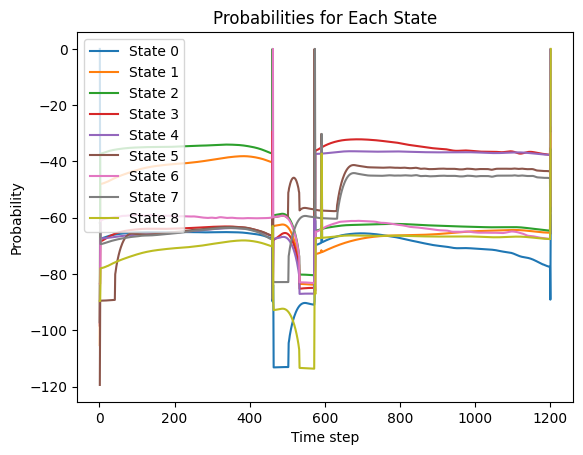

In [ ]:
def fb_alg(states, Transition, q, Duration):
    T = len(q[0])
    alpha = forward(states, Transition, q, Duration)
    beta = backward(states, Transition, q, Duration)
    fb_probs = alpha * beta

    # normalize
    fb_sum = torch.sum(alpha[T-1])
    if fb_sum:
        fb_probs = fb_probs / fb_sum
    
    #(fb_probs[2][2]).backward()
    return fb_probs

fb_probs = fb_alg(states, Transition, q, Duration).detach().numpy()
#print('q.grad:', (q.grad * 100).round().int())
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), np.log(probs), label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()